<a href="https://colab.research.google.com/github/aaaksenova/term_paper2021/blob/change/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clusterisation

In [28]:
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
import itertools

In [1]:
df = pd.read_csv('/content/drive/MyDrive/frames_billion.csv',  delimiter='\t')

In [ ]:
change = ['менять',
                  'изменять',
                  'заменять',
                  'взаимозаменять',
                  'выменять',
                  'заменять',
                  'наменять',
                  'обменять',
                  'переменять',
                  'подменять',
                  'поменять',
                  'променять',
                  'разменять',
                  'сменять']
df['ch'] = df.apply(lambda x: x['lemma_verb'] in change, axis=1)
change_df = df.loc[df.ch == True]

In [ ]:
change_df.to_csv('change_df.csv')

In [ ]:
change = ['менять',
                  'изменять',
                  'заменять',
                  'взаимозаменять',
                  'выменять',
                  'заменять',
                  'наменять',
                  'обменять',
                  'переменять',
                  'подменять',
                  'поменять',
                  'променять',
                  'разменять',
                  'сменять']
search = ['выискать',
              'наискать',
              'обыскать',
              'обыскивать',
              'отыскать',
              'отыскивать',
              'подыскать',
              'подыскивать',
              'поискать',
              'разыскать',
              'разыскивать']
find = ['находить']
hide = ['запрятать',
              'запрятывать',
              'перепрятать',
              'перепрятывать',
              'припрятать',
              'припрятывать',
              'прятать',
              'спрятать',
              'упрятать']
conceal = ['скрывать', 'скрыть']
verb_set = change + conceal + hide + find + search
df['clean'] = df.apply(lambda x: x['lemma_verb'] in set(verb_set), axis=1)
df = df.loc[df.clean == True]

In [ ]:
df["field"].replace({'менять' : 'menjatʹ', 'искать' : 'iskatʹ', 'находить' : 'naxoditʹ', 'прятать' : 'prjatatʹ', 'скрывать' : 'skryvatʹ'}, inplace=True)

In [18]:
! pip install transformers
! pip uninstall umap
! pip install umap-learn

In [32]:
from sklearn.cluster import KMeans
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
import random
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

## Clusterisation LaBSE

In [4]:
! pip install sentence_transformers

     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 1.2MB 42.8MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.1-cp37-none-any.whl size=123338 sha256=fd06f7eaaf7f9d474e511cd43e76aed991965262314a5149f07dff0858a7c5e2
  Stored in directory: /root/.cache/pip/wheels/5e/89/29/45e45adc162b50f97f71801e8b07947c9cfe2b3ae7dbf37896
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('LaBSE')

In [ ]:
embeddings_all = []
tags_all = []
model.to('cuda')
for line, tag in tqdm(zip(df['sentence'], df['field']), total=df.shape[0]):

    try: 
        embeddings = model.encode(line)
        embeddings_all.append(embeddings)
        tags_all.append(tag)
    except Exception as e:
        print(line)
        print(e)

In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(embeddings_all)
labels = kmeans.labels_

In [ ]:
subset = embeddings_all[::5]
subset_tags = tags_all[::5]
subset_labels = labels[::5]

In [ ]:
reducer = umap.UMAP()
Y = reducer.fit_transform(StandardScaler().fit_transform(subset))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[None, None, None, None, None, None, None, None, None, None]

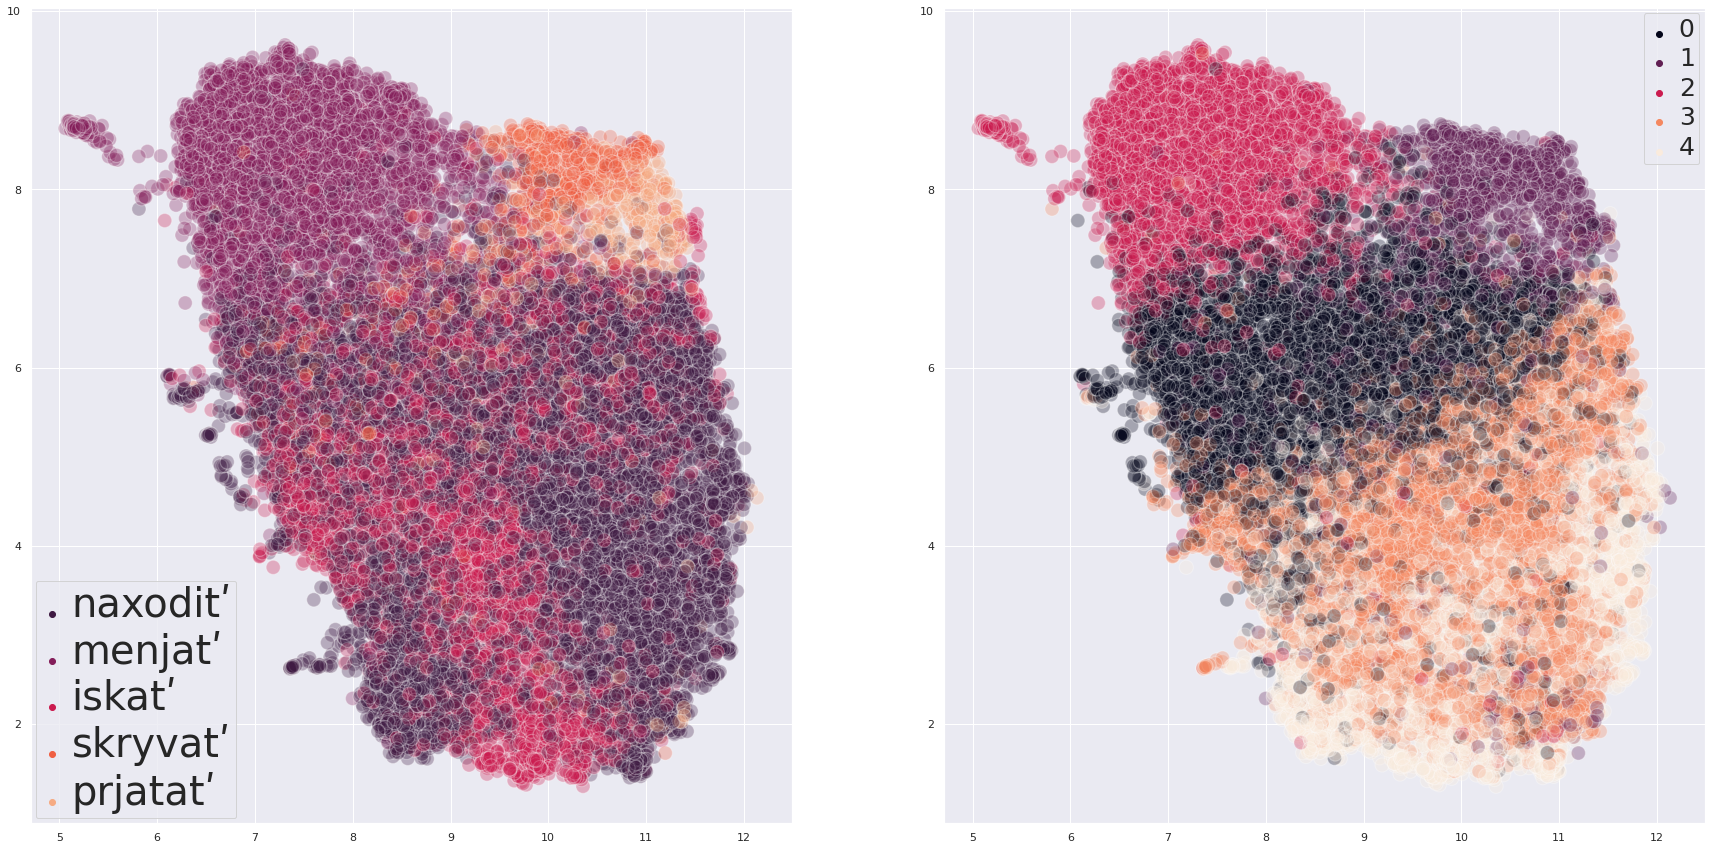

In [ ]:
fig1, ax1 = plt.subplots()
plt.figure(figsize=(30, 15))
plt.subplot(1, 2, 1)
sns.set(rc={'figure.figsize':(20, 20)})
graph1 = sns.scatterplot(Y[:, 0], Y[:, 1], s=200, alpha=.3, hue=subset_tags, palette="rocket")
graph1.get_legend()
#plt.setp(graph1.get_legend().get_texts(), fontsize='40')
plt.subplot(1, 2, 2)
sns.set(rc={'figure.figsize':(20, 20)})
graph2 = sns.scatterplot(Y[:, 0], Y[:, 1], s=200, alpha=.3, hue=subset_labels, palette="rocket")
plt.setp(graph2.get_legend().get_texts(), fontsize='25')

/usr/local/lib/python3.7/dist-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


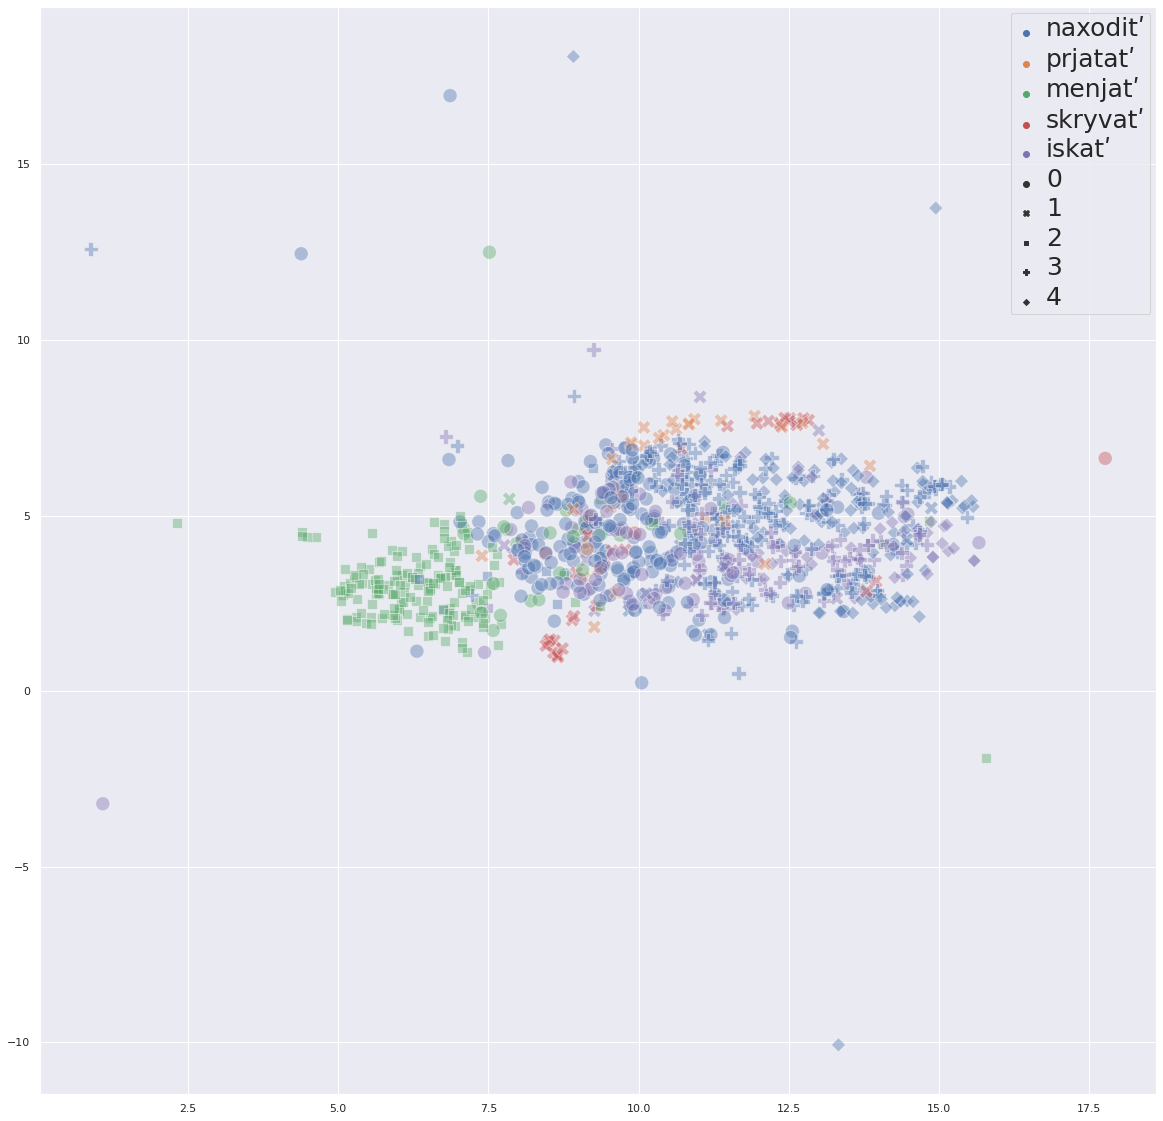

In [ ]:
Y = reducer.fit_transform(StandardScaler().fit_transform(embeddings_all))
data = [(i, j, k) for i, j, k in zip(Y, tags_all, labels)]
data_clean = random.sample(data, 1000)
X = [i[0][0] for i in data_clean]
Z = [i[0][1] for i in data_clean]
TAG = [i[1] for i in data_clean]
CLUSTER = [i[2] for i in data_clean]


graph = sns.scatterplot(X, Z, s=200, alpha=.4, hue=TAG, style=CLUSTER)
plt.setp(graph.get_legend().get_texts(), fontsize='25')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


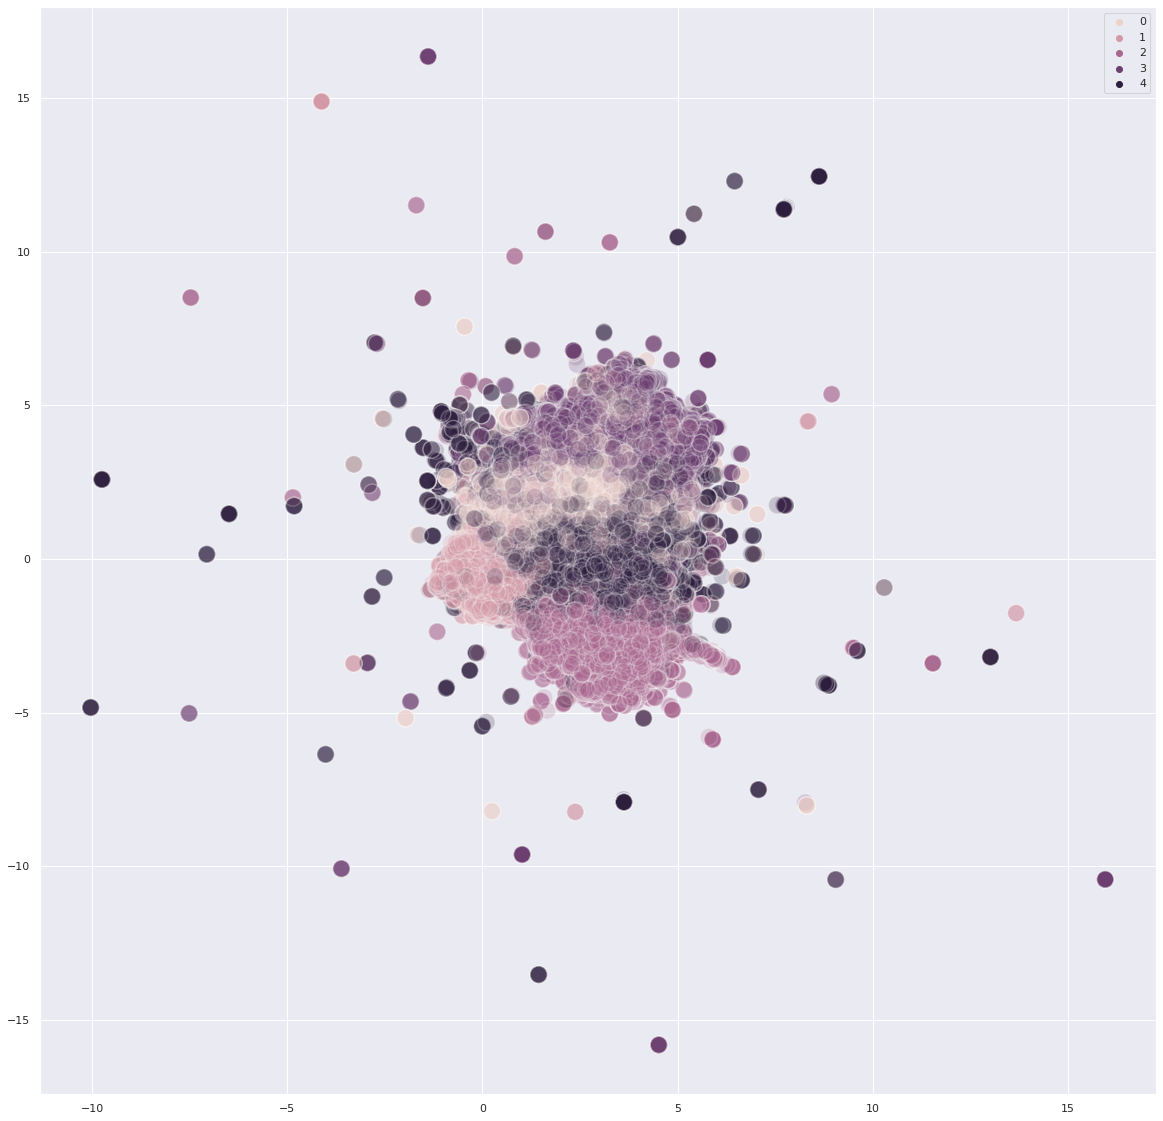

In [ ]:
sns.set(rc={'figure.figsize':(20, 20)})
sns.scatterplot(Y[:, 0], Y[:, 1], s=300, alpha=.2, hue=labels)

## Clusterisation of change in Russian

In [ ]:
! pip install sentence_transformers

In [15]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('LaBSE')

In [ ]:
embeddings_change = []
tags_change = []
model.to('cuda')
for line, tag in tqdm(zip(change_df['sentence'], change_df['field']), total=change_df.shape[0]):

    try: 
        embeddings = model.encode(line)
        embeddings_change.append(embeddings)
        tags_change.append(tag)
    except Exception as e:
        print(line)
        print(e)

### K-Means in Russian

In [ ]:
reducer = umap.UMAP()
embeddings = reducer.fit_transform(StandardScaler().fit_transform(embeddings_change))
k_2 = KMeans(n_clusters=2).fit(embeddings)
k_3 = KMeans(n_clusters=3).fit(embeddings)
k_4 = KMeans(n_clusters=4).fit(embeddings)
k_5 = KMeans(n_clusters=5).fit(embeddings)

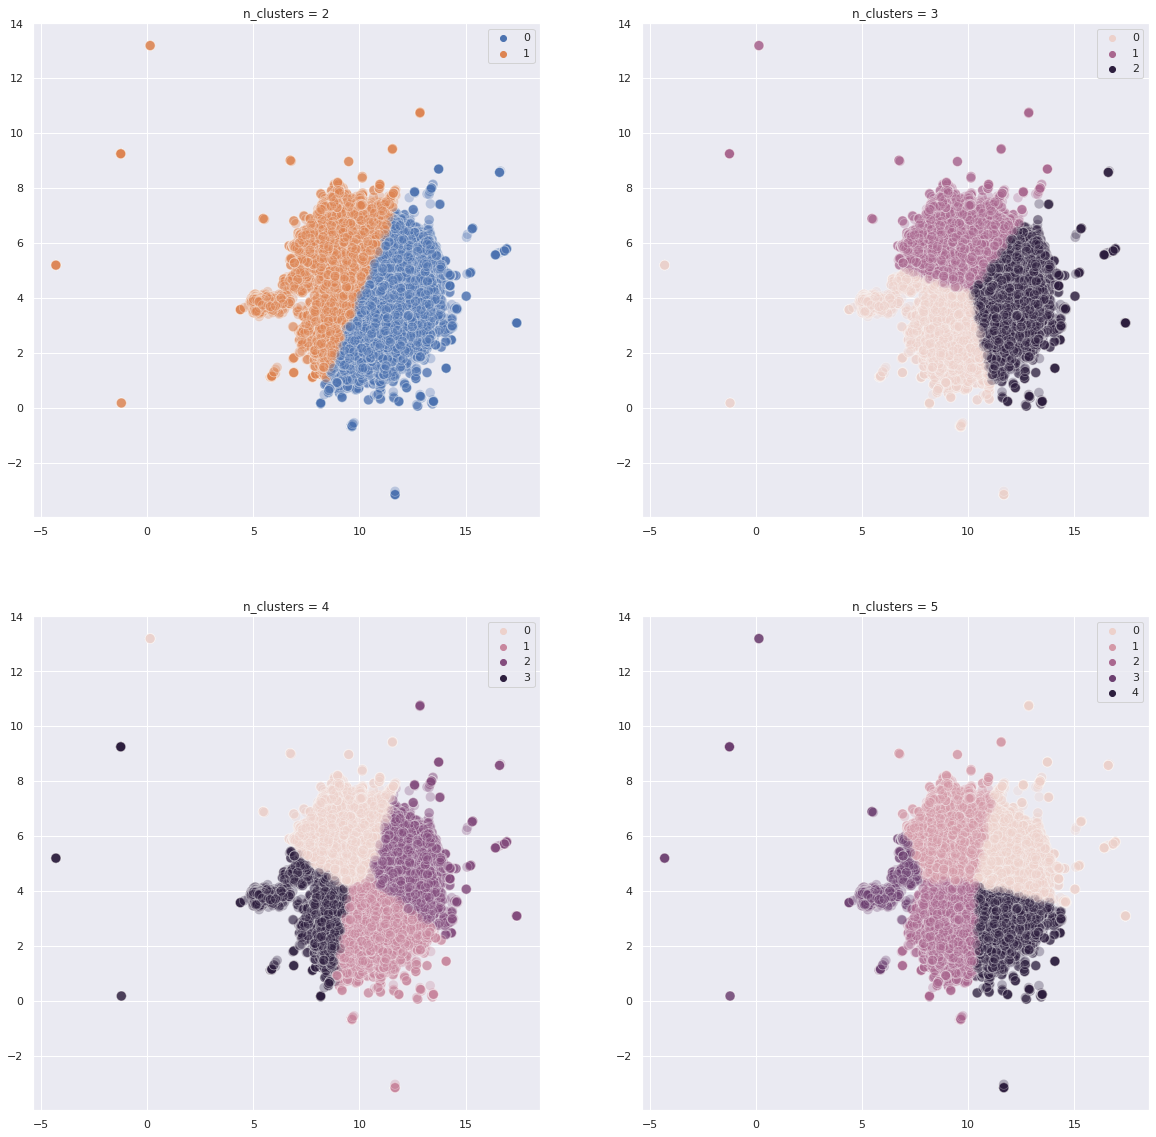

In [ ]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(20, 20))

labels = ['n_clusters = 2', 'n_clusters = 3', 'n_clusters = 4', 'n_clusters = 5']
for clustering, lab, grd in zip([k_2, k_3, k_4, k_5],
                            labels,
                         itertools.product([0, 1], repeat=2)):
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], s=100, alpha=.3, hue=clustering.labels_)
    plt.title(lab)

plt.show()

### DBSCAN in Russian

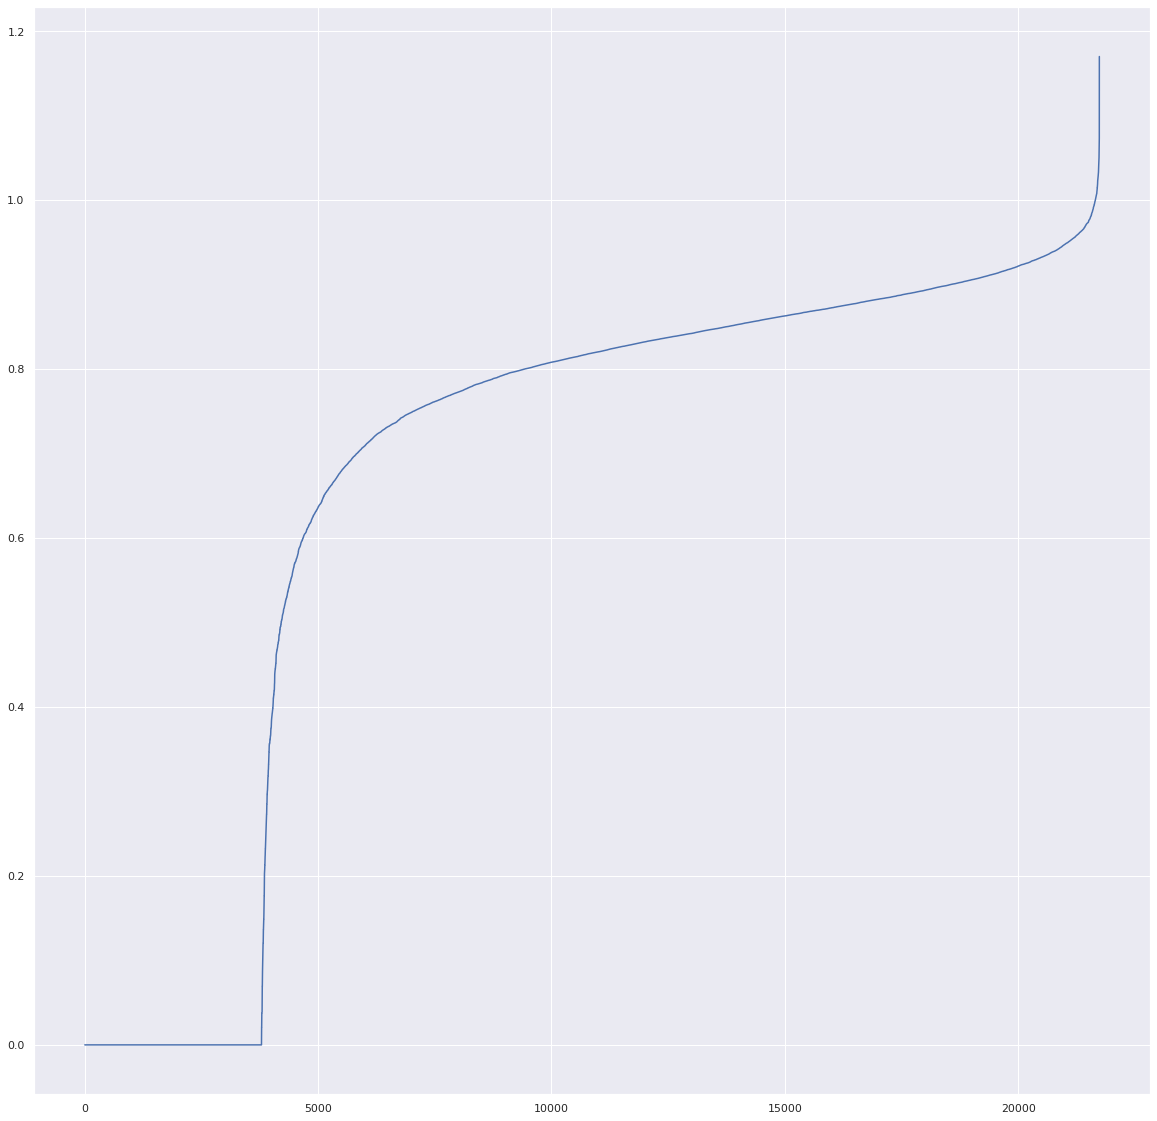

In [ ]:
neighbors = NearestNeighbors(n_neighbors=30)
neighbors_fit = neighbors.fit(embeddings_change)
distances, indices = neighbors_fit.kneighbors(embeddings_change)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
for e in np.arange(0.6, 0.7, 0.01):
    for samp in range(100, 1000, 100):
        print('Epsilon: {}  min_samples: {}'.format(e, samp))
        clustering = DBSCAN(eps=e, min_samples=samp, metric='cosine', n_jobs=-1).fit_predict(embeddings_change)
        try:
            print('Silhouette score:', metrics.silhouette_score(embeddings_change, clustering, metric='cosine'))
        except:
            print('One cluster')

Epsilon: 0.6  min_samples: 100
Silhouette score: 0.2886984
Epsilon: 0.6  min_samples: 200
Silhouette score: 0.2886984
Epsilon: 0.6  min_samples: 300
Silhouette score: 0.2886984
Epsilon: 0.6  min_samples: 400
Silhouette score: 0.2886984
Epsilon: 0.6  min_samples: 500
Silhouette score: 0.2886984
Epsilon: 0.6  min_samples: 600
Silhouette score: 0.2886984
Epsilon: 0.6  min_samples: 700
Silhouette score: 0.2886984
Epsilon: 0.6  min_samples: 800
Silhouette score: 0.2886984
Epsilon: 0.6  min_samples: 900
Silhouette score: 0.2886984
Epsilon: 0.61  min_samples: 100
Silhouette score: 0.2886984
Epsilon: 0.61  min_samples: 200
Silhouette score: 0.2886984
Epsilon: 0.61  min_samples: 300
Silhouette score: 0.2886984
Epsilon: 0.61  min_samples: 400
Silhouette score: 0.2886984
Epsilon: 0.61  min_samples: 500
Silhouette score: 0.2886984
Epsilon: 0.61  min_samples: 600
Silhouette score: 0.2886984
Epsilon: 0.61  min_samples: 700
Silhouette score: 0.2886984
Epsilon: 0.61  min_samples: 800
Silhouette score:

In [ ]:
clustering = DBSCAN(eps=0.64, min_samples=600, metric='cosine', n_jobs=-1).fit_predict(embeddings_change)

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embeddings_change)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


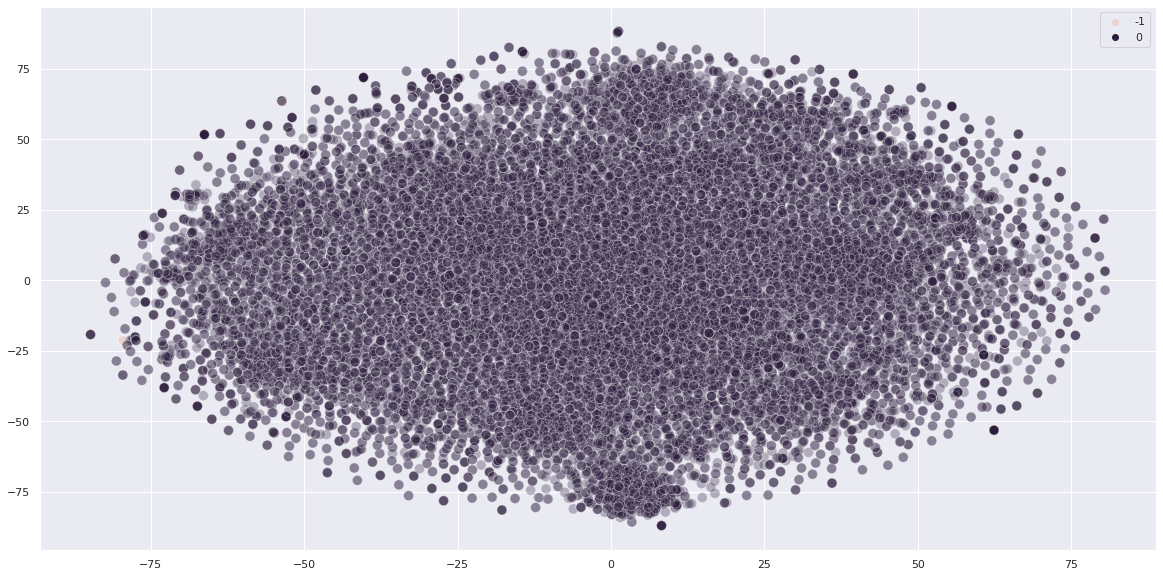

In [ ]:
sns.set(rc={'figure.figsize':(20, 10)})
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], s=100, alpha=.3, hue=clustering)

### Agglomerative Clustering in Russian

In [ ]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=9,
                                    linkage="average", affinity='cosine')
labels = model.fit_predict(embeddings_change)

In [ ]:
dic = {}
for s, cl in zip(change_df['sentence'].to_list(), labels):
    if cl not in dic :
        dic[cl] = []
    dic[cl].append(s)

## Clusterisation in Swedish

I annotated 3 corpora with UD markup to carry out preliminary tests for Swedish. The code for annotation can be found in the file **swedish_ud.py**.

In [5]:
import sqlite3
import pandas as pd

In [6]:
conn = sqlite3.connect('data.db')
cur = conn.cursor()
cur.execute("""
CREATE TABLE data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    sentence    TEXT,
    field    TEXT,
    form_subj    TEXT,
    lemma_subj TEXT,
    form_verb TEXT,
    lemma_verb TEXT,
    form_obj TEXT,
    lemma_obj TEXT
);""")

In [7]:
def tupleize_by_SVO(dict_db, corpus, text_corpus):

    TAG_SUBJECT = 'nsubj'.lower()
    TAG_OBJECT = 'obj'.lower()
    for sentence, text in zip(corpus, text_corpus):
        for word in sentence:
            if word.get('deprel') == TAG_SUBJECT:
                verb_pos = word.get('head')
                found_object = find_verb_relation_by(sentence.copy(), verb_pos, TAG_OBJECT)
                if found_object != None:

                    form_verb = sentence[int(word.get('head'))].get('form').lower()
                    lemma_verb = sentence[int(word.get('head'))].get('lemma').lower()

                    if lemma_verb.endswith('ändra') or lemma_verb.endswith('växla') or lemma_verb.endswith('byta'):
                        field = 'прятать'
                    else:
                        continue
                        
                    form_subject = word.get('form').lower()
                    lemma_subject = word.get('lemma').lower()

                    form_object = found_object.get('form').lower()
                    lemma_object = found_object.get('lemma').lower()

                    persist_key_to(dict_db, (text, field, form_subject, lemma_subject, form_verb, lemma_verb, 
                                             form_object, lemma_object))

In [8]:
def read_sentences(file):
    """
    Creates a list of sentences from the corpus
    Each sentence is a string
    :param file:
    :return:
    """
    return parse_incr(open(file))


def split_rows(sentences, column_names):
    """
    Creates a list of sentence where each sentence is a list of lines
    Each line is a dictionary of columns
    :param sentences:
    :param column_names:
    :return:
    """

    new_sentences = []
    root_values = ['0', 'ROOT', 'ROOT', 'ROOT', 'ROOT', 'ROOT', '0', 'ROOT', '0', 'ROOT']
    start = [dict(zip(column_names, root_values))]
    for sentence in sentences:
        sentence = sentence.strip()
        rows = sentence.split('\n')
        sentence = [dict(zip(column_names, row.split('\t'))) for row in rows if row[0] != '#' and not isRange(row)]
        sentence = start + sentence
        new_sentences.append(sentence)
    return new_sentences


def find_verb_relation_by(sentence, center_pos, TAG):
    for word in sentence:
        if word.get('deprel') == TAG:
            if word.get('head') == center_pos:
                break
            #deep_2_head = sentence[int(word.get('head'))].get('head')
            #if deep_2_head == center_pos:
            #    break
    else:
        return None
    return word


def isRange(id):
    pattern = re.compile("^\d+-\d+")
    return pattern.match(id)


def persist_key_to(dict_db, key):
    cur.execute("""
        INSERT INTO data (sentence, field, form_subj, 
        lemma_subj, form_verb, lemma_verb, 
        form_obj, lemma_obj) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        """, key)
    dict_db.commit()

In [9]:
! pip install conllu

In [10]:
import os
import tarfile
import sqlite3
from conllu import parse
from conllu import parse_incr, parse_tree_incr
import shutil

In [ ]:
for train_file in ['/content/drive/MyDrive/swe_ud.txt', '/content/drive/MyDrive/swe_ud1.txt', '/content/drive/MyDrive/swe_ud2.txt']:
    column_names = ['id', 'form', 'lemma', 'cpostag', 'postag', 'feats', 'head', 'deprel', 'phead', 'pdeprel']
    
    for sentences in tqdm(parse_incr(open(train_file)), total=1018550):
        text_corpus = [sentences.metadata['text']]
        sentences = [sentences.serialize()]
        try:
            formatted_corpus = split_rows(sentences, column_names)
        except:
            continue
        tupleize_by_SVO(conn, formatted_corpus, text_corpus)

In [ ]:
df = pd.read_sql('SELECT * FROM data', conn)
df

Empty DataFrame
Columns: [id, sentence, field, form_subj, lemma_subj, form_verb, lemma_verb, form_obj, lemma_obj]
Index: []

In [ ]:
df.to_csv('swedish_collected.csv')

In [13]:
df = pd.read_csv('swedish_collected.csv')

In [16]:
model = SentenceTransformer('LaBSE')

In [17]:
embeddings_change = []
tags_change = []
model.to('cuda')
for line, tag in tqdm(zip(df['sentence'], df['field']), total=df.shape[0]):

    try: 
        embeddings = model.encode(line)
        embeddings_change.append(embeddings)
        tags_change.append(tag)
    except Exception as e:
        print(line)
        print(e)

### K-Means Swedish

In [20]:
reducer = umap.UMAP()
embeddings = reducer.fit_transform(StandardScaler().fit_transform(embeddings_change))
k_2 = KMeans(n_clusters=2).fit(embeddings)
k_3 = KMeans(n_clusters=3).fit(embeddings)
k_4 = KMeans(n_clusters=4).fit(embeddings)
k_5 = KMeans(n_clusters=5).fit(embeddings)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


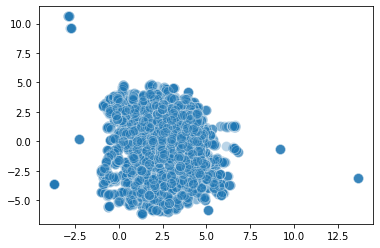

In [23]:
sns.scatterplot(embeddings[:, 0], embeddings[:, 1], s=100, alpha=.3)

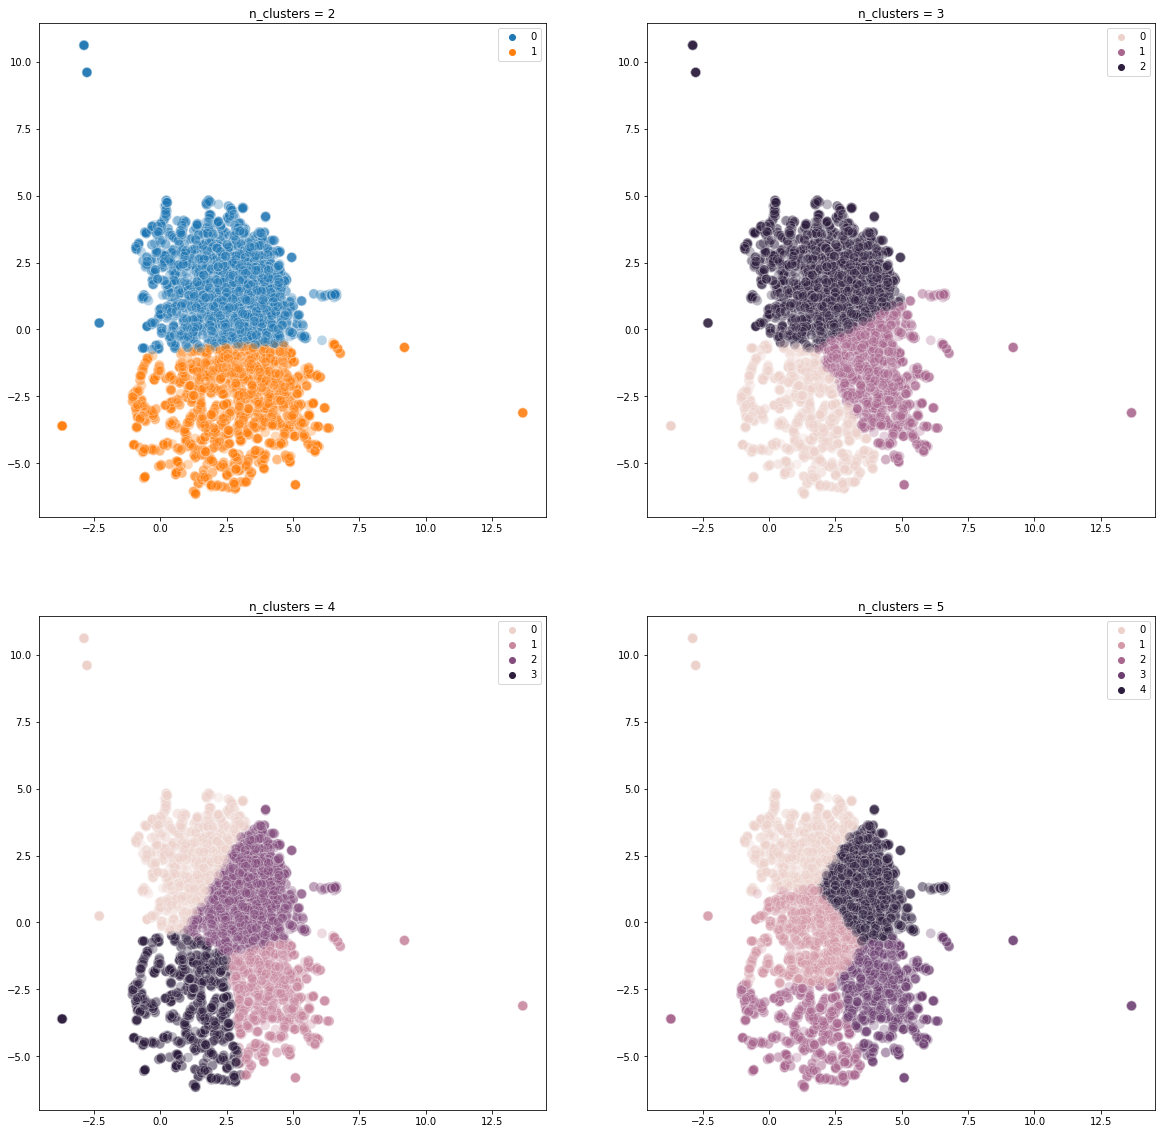

In [31]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(20, 20))

labels = ['n_clusters = 2', 'n_clusters = 3', 'n_clusters = 4', 'n_clusters = 5']
for clustering, lab, grd in zip([k_2, k_3, k_4, k_5],
                            labels,
                         itertools.product([0, 1], repeat=2)):
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], s=100, alpha=.3, hue=clustering.labels_)
    plt.title(lab)

plt.show()

### DBSCAN Swedish

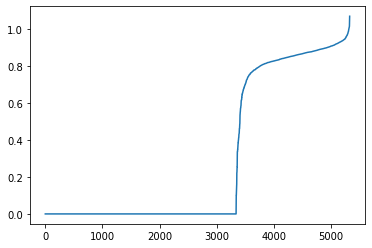

In [33]:
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(embeddings_change)
distances, indices = neighbors_fit.kneighbors(embeddings_change)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [34]:
for e in np.arange(0.6, 1, 0.01):
    for samp in range(100, 1000, 100):
        print('Epsilon: {}  min_samples: {}'.format(e, samp))
        clustering = DBSCAN(eps=e, min_samples=samp, metric='cosine', n_jobs=-1).fit_predict(embeddings_change)
        try:
            print('Silhouette score:', metrics.silhouette_score(embeddings_change, clustering, metric='cosine'))
        except:
            print('One cluster')

Epsilon: 0.6  min_samples: 100
Silhouette score: 0.33406126
Epsilon: 0.6  min_samples: 200
Silhouette score: 0.33406126
Epsilon: 0.6  min_samples: 300
Silhouette score: 0.33406126
Epsilon: 0.6  min_samples: 400
Silhouette score: 0.33406126
Epsilon: 0.6  min_samples: 500
Silhouette score: 0.33406126
Epsilon: 0.6  min_samples: 600
Silhouette score: 0.33406126
Epsilon: 0.6  min_samples: 700
Silhouette score: 0.33406126
Epsilon: 0.6  min_samples: 800
Silhouette score: 0.33406126
Epsilon: 0.6  min_samples: 900
Silhouette score: 0.33406126
Epsilon: 0.61  min_samples: 100
Silhouette score: 0.33406126
Epsilon: 0.61  min_samples: 200
Silhouette score: 0.33406126
Epsilon: 0.61  min_samples: 300
Silhouette score: 0.33406126
Epsilon: 0.61  min_samples: 400
Silhouette score: 0.33406126
Epsilon: 0.61  min_samples: 500
Silhouette score: 0.33406126
Epsilon: 0.61  min_samples: 600
Silhouette score: 0.33406126
Epsilon: 0.61  min_samples: 700
Silhouette score: 0.33406126
Epsilon: 0.61  min_samples: 800
S

In [35]:
clustering = DBSCAN(eps=0.63, min_samples=400, metric='cosine', n_jobs=-1).fit_predict(embeddings_change)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


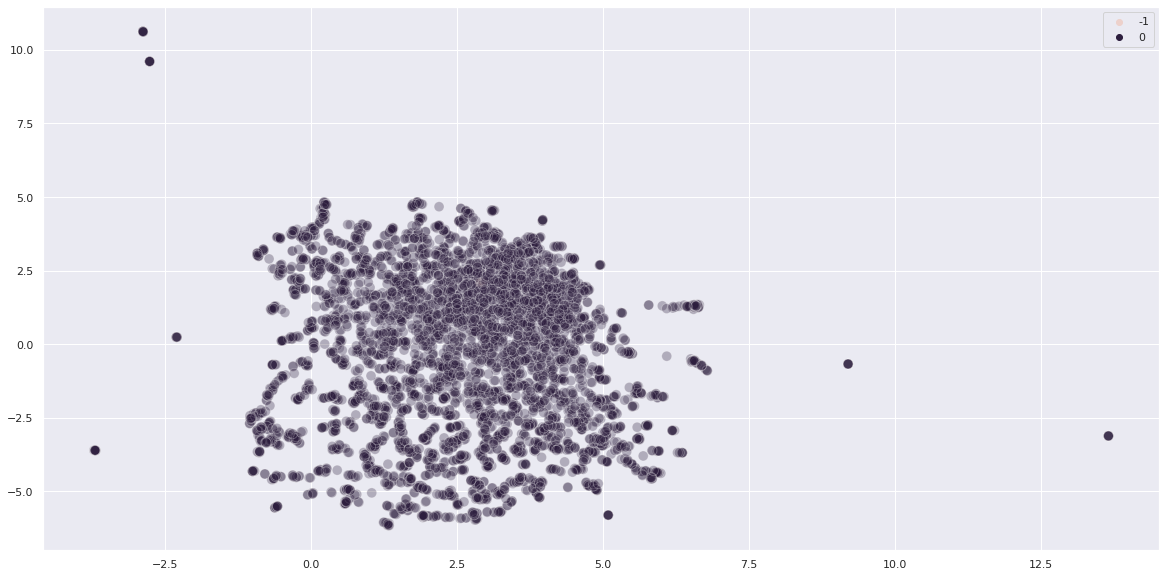

In [36]:
sns.set(rc={'figure.figsize':(20, 10)})
sns.scatterplot(embeddings[:, 0], embeddings[:, 1], s=100, alpha=.3, hue=clustering)

### Agglomerative Clustering Swedish

In [37]:
from sklearn.cluster import AgglomerativeClustering

In [41]:
model = AgglomerativeClustering(n_clusters=9,
                                    linkage="average", affinity='euclidean')
labels = model.fit_predict(embeddings_change)

In [42]:
dic = {}
for s, cl in zip(df['sentence'].to_list(), labels):
    if cl not in dic :
        dic[cl] = []
    dic[cl].append(s)